In [1]:
import json

In [2]:
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcEnrichment, CalcAUC, CalcROC
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
t = pd.read_csv('results/scaffold_split_0_new_nobio_platinum')

In [6]:
t.head(1)

,Unnamed: 0,all_targets,all_preds,all_losses,mean_loss,all_bioactive_rank,median_bioactive_rank,bioactive_accuracy,n_bioactive,n_generated,generated_accuracy,ccdc_accuracy,n_heavy_atoms,n_rotatable_bonds,ef20_pred,ef20_ccdc
0,COc1ccc(-c2cn(C)c(=O)c3cc(C(=O)NC4CCS(=O)(=O)C...,"[0.0, 0.0, 0.0, 1.5365843, 1.2933521, 1.101103...","[1.49768, 1.5875969, 1.4981818, 1.4671174, 1.6...","[2.2430453300476074, 2.5204639434814453, 2.244...",0.411216,[ 8 19 10],10.0,0.0,3.0,100.0,False,False,32.0,5.0,2.0,3.0


In [7]:
active_ratio = 0.1
regression_table = pd.DataFrame(columns=['split', 'average_type', 'rmse_all', 'rmse_gen', 'rmse_bio', 'r2_all', 'r2_gen', 'pearson_all', 'pearson_gen'])
bioactive_accuracy_table = pd.DataFrame(columns=['split', 'top1_acc', 'topn_acc', 'q1', 'med', 'q3'])
ranking_table = pd.DataFrame(columns=['split', 'ranker', 'ef20', 'bedroc'])

for split in ['scaffold', 'random'] :

    for iteration in range(2) :
        
        t = pd.read_csv(f'results/{split}_split_{iteration}_new_nobio_platinum')
        t = t[(t['n_generated'] == 100) & (t['Unnamed: 0'] != 'Micro')]

        top1_accuracies = []
        bioactive_ranks = []
        all_targets = []
        all_preds = []
        all_generated_targets = []
        all_generated_preds = []
        all_generated_activities = []
        all_bioactive_preds = []
        bedrocs_model = []
        bedrocs_ccdc = []
        bedrocs_random = []
        ef_model = []
        ef_ccdc = []
        ef_random = []
        auc_model = []
        auc_ccdc = []
        auc_random = []
        n_rotatable_bonds = []
        relative_ranks_model = []
        relative_ranks_ccdc = []
        relative_ranks_random = []
        r2s_all = []
        r2s_gen = []
        pearsons_all = []
        pearsons_gen = []
        spearmans_all = []
        spearmans_gen = []
        rmses_all = []
        rmses_gen = []
        rmses_bio = []
        for mol_i in tqdm(range(len(t) - 1)) :

            targets = json.loads(t.iloc[mol_i, 1])
            targets = np.array(targets)
            generated = targets != 0
            generated_targets = targets[generated]
            
            preds = json.loads(t.iloc[mol_i, 2])
            preds = np.array(preds)
            
            all_targets.extend(targets)
            all_preds.extend(preds)

            r2s_all.append(r2_score(targets, preds))
            pearsons_all.append(pearsonr(targets, preds)[0])
            spearmans_all.append(spearmanr(targets, preds)[0])
            rmses_all.append(mean_squared_error(targets, preds, squared=False))

            is_bioactive = targets == 0
            pred_ranks = preds.argsort().argsort()
            bioactive_pred_ranks = pred_ranks[is_bioactive]
            bioactive_ranks.extend(bioactive_pred_ranks.tolist())

            top1_accuracies.append(0 in bioactive_pred_ranks)

            generated_preds = preds[generated]
            all_generated_targets.extend(generated_targets)
            all_generated_preds.extend(generated_preds)

            r2s_gen.append(r2_score(generated_targets, generated_preds))
            pearsons_gen.append(pearsonr(generated_targets, generated_preds)[0])
            spearmans_gen.append(spearmanr(generated_targets, generated_preds)[0])
            rmses_gen.append(mean_squared_error(generated_targets, generated_preds, squared=False))
            
            bioactive_preds = preds[~generated]
            all_bioactive_preds.extend(bioactive_preds)
            rmses_bio.append(np.mean(bioactive_preds))

            actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
            activity = [True if i in actives_i else False for i in range(len(generated_preds))]
            all_generated_activities.extend(activity)
            preds_array = np.array(list(zip(generated_preds, activity)))

            relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
            ranks_ccdc = np.array(range(len(generated_preds)))
            relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
            np.random.shuffle(generated_preds)
            relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

            sorting = np.argsort(preds_array[:, 0])
            sorted_preds_array = preds_array[sorting]

            ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
            bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
            auc_model.append(CalcAUC(sorted_preds_array, col=1))

            ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
            bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
            auc_ccdc.append(CalcAUC(preds_array, col=1))

            np.random.shuffle(preds_array)
            ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
            bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
            auc_random.append(CalcAUC(preds_array, col=1))

            n_rotatable_bonds.append(int(t.iloc[mol_i, 13]))

            model_roc = CalcROC(sorted_preds_array, col=1)
            ccdc_roc = CalcROC(preds_array, col=1)

        q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

        new_row = pd.Series({'split' : split,
                              'top1_acc' : np.mean(top1_accuracies),
                              'topn_acc' : np.mean(t['bioactive_accuracy']),
                              'q1' : q1,
                              'med' : med,
                              'q3' : q3})
        bioactive_accuracy_table = bioactive_accuracy_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'Model',
                              'ef20' : np.mean(ef_model),
                              'bedroc' : np.mean(bedrocs_model)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'Random',
                              'ef20' : np.mean(ef_random),
                              'bedroc' : np.mean(bedrocs_random)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)

        new_row = pd.Series({'split' : split,
                              'ranker' : 'CCDC',
                              'ef20' : np.mean(ef_ccdc),
                              'bedroc' : np.mean(bedrocs_ccdc)})
        ranking_table = ranking_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'macro',
                              'rmse_all' : np.mean(rmses_all),
                              'rmse_gen' : np.mean(rmses_gen),
                             'rmse_bio' : np.mean(rmses_bio),
                              'r2_all' : np.mean(r2s_all),
                              'r2_gen' : np.mean(r2s_gen),
                                'pearson_all' : np.mean(pearsons_all),
                            'pearson_gen' : np.mean(pearsons_gen),
                            'spearman_all' : np.mean(spearmans_all),
                            'spearman_gen' : np.mean(spearmans_gen)})
        regression_table = regression_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'micro',
                              'rmse_all' : mean_squared_error(all_targets, all_preds, squared=False),
                              'rmse_gen' : mean_squared_error(all_generated_targets, all_generated_preds, squared=False),
                              'rmse_bio' : np.mean(all_bioactive_preds),
                              'r2_all' : r2_score(all_targets, all_preds),
                              'r2_gen' : r2_score(all_generated_targets, all_generated_preds),
                            'pearson_all' : pearsonr(all_targets, all_preds)[0],
                            'pearson_gen' : pearsonr(all_generated_targets, all_generated_preds)[0],
                            'spearman_all' : spearmanr(all_targets, all_preds)[0],
                            'spearman_gen' : spearmanr(all_generated_targets, all_generated_preds)[0]})
        regression_table = regression_table.append(new_row, ignore_index=True)

100%|██████████████████████████████████████| 2829/2829 [00:06<00:00, 451.53it/s]


In [8]:
regression_table

,split,average_type,rmse_all,rmse_gen,rmse_bio,r2_all,r2_gen,pearson_all,pearson_gen,spearman_all,spearman_gen
0,scaffold,macro,0.525568,0.493078,1.624882,-0.356026,-0.506714,0.378401,0.390093,0.372002,0.371615
1,scaffold,micro,0.573978,0.543850,1.644940,0.480717,0.507412,0.705572,0.723642,0.683341,0.693462
2,scaffold,macro,0.550335,0.518390,1.675495,-0.415462,-0.573556,0.364751,0.371883,0.354121,0.352680
3,scaffold,micro,0.593697,0.563441,1.688559,0.444424,0.471284,0.692718,0.710446,0.670382,0.680336
4,random,macro,0.512831,0.482405,1.532752,-0.299796,-0.460923,0.393417,0.401422,0.385654,0.383907
5,random,micro,0.564427,0.536958,1.552542,0.497854,0.519818,0.716762,0.733674,0.695999,0.705199
6,random,macro,0.514052,0.481425,1.586033,-0.290151,-0.418268,0.385395,0.397199,0.379279,0.378599
7,random,micro,0.569463,0.540634,1.596842,0.488854,0.513220,0.708834,0.726238,0.688860,0.698470


<AxesSubplot:ylabel='Count'>

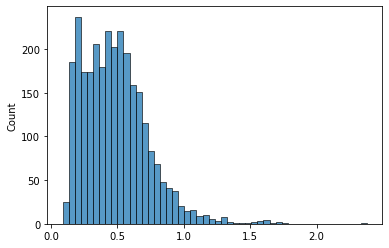

In [10]:
sns.histplot(rmses_gen)

<AxesSubplot:ylabel='Count'>

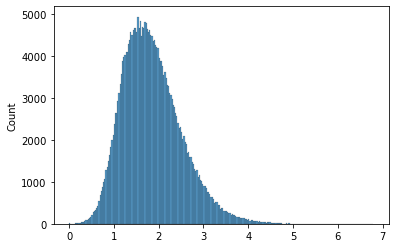

In [11]:
sns.histplot(all_generated_preds)

<AxesSubplot:ylabel='Count'>

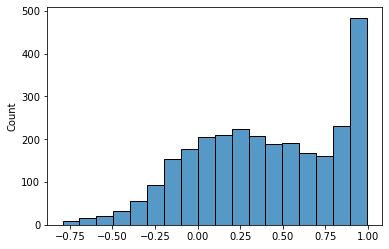

In [12]:
sns.histplot(pearsons_gen)

<AxesSubplot:ylabel='Count'>

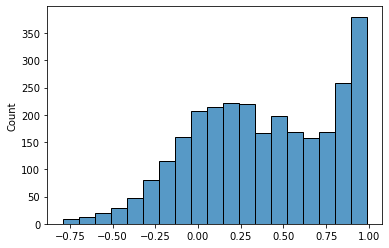

In [13]:
sns.histplot(spearmans_gen)

In [14]:
np.mean(all_generated_targets)

1.8494068057809114

In [15]:
np.std(all_generated_targets)

0.7748849921965653

<AxesSubplot:ylabel='Count'>

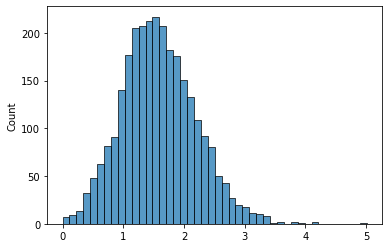

In [16]:
sns.histplot(rmses_bio)

In [17]:
bioactive_accuracy_table

,split,top1_acc,topn_acc,q1,med,q3
0,scaffold,0.091198,0.089784,8.0,27.0,61.0
1,scaffold,0.090845,0.089046,7.0,27.0,60.0
2,random,0.091552,0.091987,7.0,25.0,56.0
3,random,0.079887,0.079299,8.0,27.0,59.0


In [18]:
ranking_table

,split,ranker,ef20,bedroc
0,scaffold,Model,2.126723,0.302317
1,scaffold,Random,1.014846,0.115751
2,scaffold,CCDC,1.191410,0.148213
3,scaffold,Model,2.034995,0.279369
4,scaffold,Random,1.008660,0.114805
5,scaffold,CCDC,1.191410,0.148213
6,random,Model,2.247791,0.335423
7,random,Random,0.984093,0.117083
8,random,CCDC,1.191410,0.148213
9,random,Model,2.235596,0.335904


<AxesSubplot:xlabel='ranker', ylabel='ef20'>

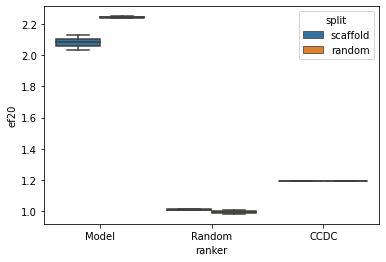

In [19]:
sns.boxplot(data=ranking_table, x='ranker', y='ef20', hue='split')

<AxesSubplot:xlabel='ranker', ylabel='bedroc'>

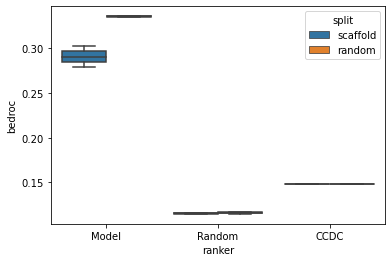

In [20]:
sns.boxplot(data=ranking_table, x='ranker', y='bedroc', hue='split')

<AxesSubplot:xlabel='ranker', ylabel='bedroc'>

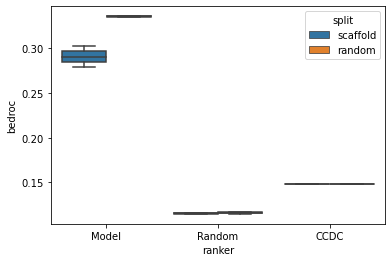

In [21]:
sns.boxplot(data=ranking_table, x='ranker', y='bedroc', hue='split')

In [50]:
iters_mean_top1_accuracies

[0.2395128552097429, 0.2496493688639551]

In [51]:
iters_mean_topn_accuracies

[0.23126126126126126, 0.24128142485064197]

In [52]:
iters_mean_ef20s_ccdc

[1.145466847090663, 1.1374474053295933]

In [53]:
iters_mean_ef20s_model

[1.7949932341001353, 1.829593267882188]

In [54]:
iters_mean_ef20s_random

[1.0027063599458728, 1.032959326788219]

In [55]:
iters_mean_bedrocs_ccdc

[0.14755270495366615, 0.13391146667748718]

In [56]:
iters_mean_bedrocs_model

[0.2393640142580535, 0.24085583789276843]

In [57]:
iters_mean_bedrocs_random

[0.11391460350427424, 0.11460384185116546]

In [58]:
active_ratio = 0.1
iters_q1s = []
iters_medians = []
iters_q3s = []
iters_mean_top1_accuracies = []
iters_mean_topn_accuracies = []
iters_mean_ef20s_ccdc = []
iters_mean_ef20s_model = []
iters_mean_ef20s_random = []
iters_mean_bedrocs_ccdc = []
iters_mean_bedrocs_model = []
iters_mean_bedrocs_random = []

for iteration in range(2) :
    t = pd.read_csv(f'results/random_split_{iteration}_new_pdbbind')
    t = t[(t['n_generated'] == 100) & (t['Unnamed: 0'] != 'Micro')]
    
    top1_accuracies = []
    bioactive_ranks = []
    all_targets = []
    all_preds = []
    all_activities = []
    bedrocs_model = []
    bedrocs_ccdc = []
    bedrocs_random = []
    ef_model = []
    ef_ccdc = []
    ef_random = []
    auc_model = []
    auc_ccdc = []
    auc_random = []
    n_rotatable_bonds = []
    relative_ranks_model = []
    relative_ranks_ccdc = []
    relative_ranks_random = []
    for mol_i in tqdm(range(len(t) - 1)) :

        targets = json.loads(t.iloc[mol_i, 1])
        targets = np.array(targets)
        generated = targets != 0
        generated_targets = targets[generated]
        preds = json.loads(t.iloc[mol_i, 2])
        preds = np.array(preds)

        is_bioactive = targets == 0
        pred_ranks = preds.argsort().argsort()
        bioactive_pred_ranks = pred_ranks[is_bioactive]
        bioactive_ranks.extend(bioactive_pred_ranks.tolist())

        top1_accuracies.append(0 in bioactive_pred_ranks)

        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        n_rotatable_bonds.append(int(t.iloc[mol_i, 13]))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)
        
    q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])
    iters_q1s.append(q1)
    iters_medians.append(med)
    iters_q3s.append(q3)
    
    iters_mean_top1_accuracies.append(np.mean(top1_accuracies))
    iters_mean_topn_accuracies.append(np.mean(t['bioactive_accuracy']))
    iters_mean_ef20s_ccdc.append(np.mean(ef_ccdc))
    iters_mean_ef20s_model.append(np.mean(ef_model))
    iters_mean_ef20s_random.append(np.mean(ef_random))
    iters_mean_bedrocs_ccdc.append(np.mean(bedrocs_ccdc))
    iters_mean_bedrocs_model.append(np.mean(bedrocs_model))
    iters_mean_bedrocs_random.append(np.mean(bedrocs_random))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:00<00:00, 1109.49it/s]


In [59]:
iters_mean_top1_accuracies

[0.3356643356643357, 0.3413333333333333]

In [60]:
iters_mean_topn_accuracies

[0.3270949720670391, 0.3307035064358633]

In [61]:
iters_mean_ef20s_ccdc

[1.1874125874125874, 1.1286666666666667]

In [62]:
iters_mean_ef20s_model

[2.0027972027972027, 1.9866666666666666]

In [63]:
iters_mean_ef20s_random

[0.9594405594405594, 0.9633333333333334]

In [64]:
iters_mean_bedrocs_ccdc

[0.14196399576798885, 0.13630780100544057]

In [65]:
iters_mean_bedrocs_model

[0.28467338490313476, 0.27757118232931144]

In [66]:
iters_mean_bedrocs_random

[0.10925192223684312, 0.11393144960213264]

In [ ]:



for mol_i in t.index :
    
    targets = json.loads(t.loc[mol_i, 'all_targets'])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.loc[mol_i, 'all_preds'])
        preds = np.array(preds)
        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        
        n_rotatable_bonds.append(int(t.loc[mol_i, 'n_rotatable_bonds']))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)

The issue is that we can't rank conformations with CCDC from different molecules.
In practice, we would rank conformations for the same molecule.

In [31]:
top1_accuracies = []
bioactive_ranks = []
n_non_gen = 0

for mol_i in tqdm(range(len(t) - 1)) :
    
    targets = json.loads(t.iloc[mol_i, 1])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.iloc[mol_i, 2])
        preds = np.array(preds)
        
        is_bioactive = targets == 0
        pred_ranks = preds.argsort().argsort()
        bioactive_pred_ranks = pred_ranks[is_bioactive]
        bioactive_ranks.extend(bioactive_pred_ranks.tolist())

        top1_accuracies.append(0 in bioactive_pred_ranks)
    else :
        n_non_gen += 1
        
    q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 7711.02it/s]


<AxesSubplot:ylabel='Count'>

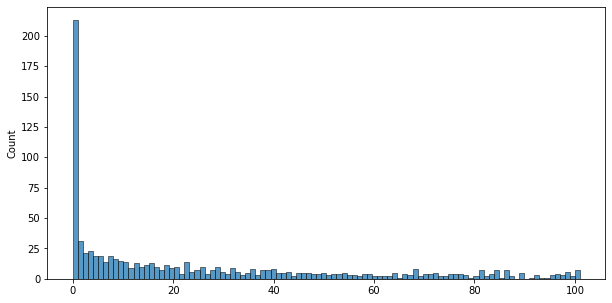

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(bioactive_ranks, bins=100)

In [39]:
q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

In [33]:
np.mean(top1_accuracies)

0.2395128552097429

In [34]:
np.mean(t['bioactive_accuracy'])

0.23126126126126126

In [45]:
active_ratio = 0.1

all_targets = []
all_preds = []
all_activities = []
bedrocs_model = []
bedrocs_ccdc = []
bedrocs_random = []
ef_model = []
ef_ccdc = []
ef_random = []
auc_model = []
auc_ccdc = []
auc_random = []
n_rotatable_bonds = []
relative_ranks_model = []
relative_ranks_ccdc = []
relative_ranks_random = []
for mol_i in t.index :
    
    targets = json.loads(t.loc[mol_i, 'all_targets'])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.loc[mol_i, 'all_preds'])
        preds = np.array(preds)
        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(generated_preds, activity)))
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(generated_preds)
        relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]
        
        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        
        n_rotatable_bonds.append(int(t.loc[mol_i, 'n_rotatable_bonds']))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)
        
#         plt.plot(model_roc.FPR, model_roc.TPR, label='model')
#         plt.plot(ccdc_roc.FPR, ccdc_roc.TPR, label='ccdc')
#         plt.legend()
#         plt.show()

In [46]:
thresholds = [n for n in np.arange(0, 1, 0.01)]
retrieved_ccdc = []
retrieved_model = []
retrieved_random = []
relative_ranks_ccdc = np.array(relative_ranks_ccdc)
relative_ranks_model = np.array(relative_ranks_model)
relative_ranks_random = np.array(relative_ranks_random)
all_activities = np.array(all_activities)
n_actives = sum(all_activities)
for threshold in tqdm(thresholds) :
    ccdc_below_threshold = relative_ranks_ccdc < threshold
    retrieved_ccdc.append((all_activities * ccdc_below_threshold).sum() / n_actives)
    model_below_threshold = relative_ranks_model < threshold
    retrieved_model.append((all_activities * model_below_threshold).sum() / n_actives)
    random_below_threshold = relative_ranks_random < threshold
    retrieved_random.append((all_activities * random_below_threshold).sum() / n_actives)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1956.59it/s]


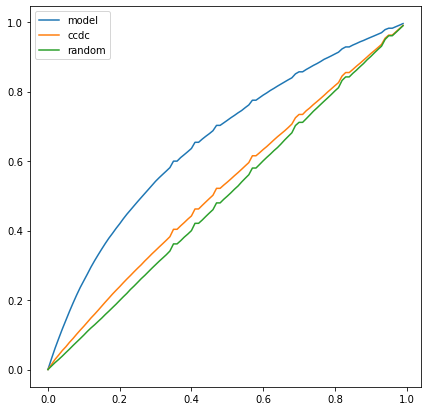

In [47]:
plt.figure(figsize=(7,7))
plt.plot(thresholds, retrieved_model, label='model')
plt.plot(thresholds, retrieved_ccdc, label='ccdc')
plt.plot(thresholds, retrieved_random, label='random')
plt.legend()

<AxesSubplot:ylabel='Count'>

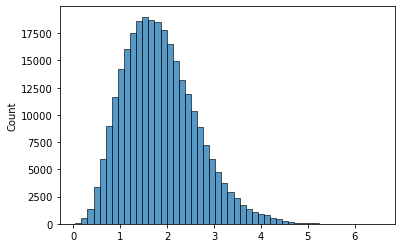

In [48]:
sns.histplot(all_targets, bins=50)

In [49]:
preds_array = np.array(list(zip(all_preds, all_activities)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

<AxesSubplot:ylabel='Count'>

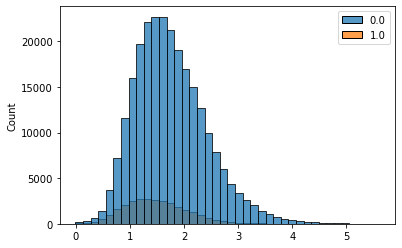

In [50]:
sns.histplot(x=preds_array[:,0], hue=preds_array[:,1], bins=40)

In [51]:
CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])

[1.5835689045936396]

In [52]:
CalcEnrichment(preds_array, col=1, fractions=[0.2])

[1.0]

In [53]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

0.22759981591469267

In [54]:
CalcBEDROC(preds_array, col=1, alpha=20)

0.11568036983559946

In [55]:
from scipy.stats import describe

In [56]:
describe(bedrocs_model)

DescribeResult(nobs=2830, minmax=(5.012808460062209e-08, 1.0000000000000002), mean=0.30077151364574367, variance=0.07668078759827629, skewness=0.7247475251450797, kurtosis=-0.5852457616362852)

In [57]:
describe(bedrocs_ccdc)

DescribeResult(nobs=2830, minmax=(2.0782208626088467e-08, 0.7994626392063164), mean=0.14823411097499825, variance=0.02111130102595104, skewness=1.1590116379714668, kurtosis=0.9886150131690221)

In [58]:
describe(bedrocs_random)

DescribeResult(nobs=2830, minmax=(1.7942364576203762e-05, 0.6373807556479762), mean=0.11831926970462527, variance=0.011157592996796126, skewness=1.044991030200524, kurtosis=0.7533248896057643)

In [59]:
np.median(bedrocs_model)

0.22556249408944068

In [60]:
np.median(bedrocs_ccdc)

0.10645582141598874

In [61]:
np.median(bedrocs_random)

0.09098231953049013

In [62]:
describe(ef_model)

DescribeResult(nobs=2830, minmax=(0.0, 5.0), mean=2.0969964664310954, variance=2.2757597985028863, skewness=0.32895682392746084, kurtosis=-0.9797567717858549)

In [63]:
describe(ef_ccdc)

DescribeResult(nobs=2830, minmax=(0.0, 4.5), mean=1.1918727915194347, variance=0.6487497611187512, skewness=0.49057744639201134, kurtosis=0.12156073172017212)

In [64]:
describe(ef_random)

DescribeResult(nobs=2830, minmax=(0.0, 3.5), mean=1.0286219081272086, variance=0.3669783052109212, skewness=0.44018243268056817, kurtosis=0.06961867460962745)

In [65]:
describe(auc_model)

DescribeResult(nobs=2830, minmax=(0.02333333333333334, 1.0), mean=0.677539065567334, variance=0.04679344853203743, skewness=-0.5061816470097596, kurtosis=-0.6047958531287909)

In [66]:
describe(auc_ccdc)

DescribeResult(nobs=2830, minmax=(0.025555555555555554, 0.9366666666666668), mean=0.5306148409893993, variance=0.01728782470929811, skewness=-0.1126853506384679, kurtosis=0.22070012051173427)

In [67]:
describe(auc_random)

DescribeResult(nobs=2830, minmax=(0.1988888888888889, 0.8066666666666666), mean=0.5056230859835099, variance=0.008955397381742773, skewness=0.025764035872779607, kurtosis=-0.1018998028184348)

<AxesSubplot:>

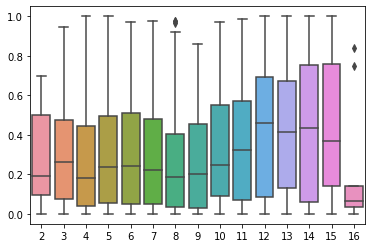

In [68]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_model)

<AxesSubplot:>

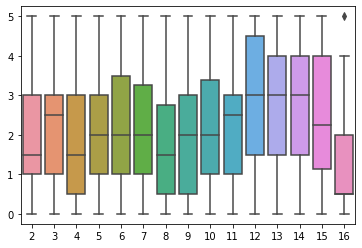

In [69]:
sns.boxplot(x=n_rotatable_bonds, y=ef_model)

<AxesSubplot:>

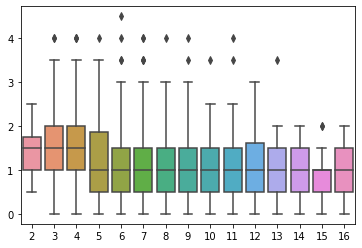

In [70]:
sns.boxplot(x=n_rotatable_bonds, y=ef_ccdc)

<AxesSubplot:>

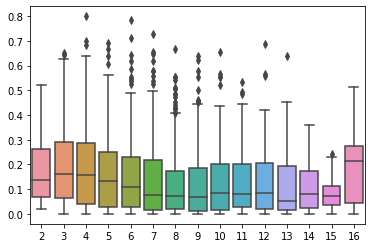

In [71]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_ccdc)

In [35]:
actives_i = np.argsort(targets)[:int(len(targets) / 10)]
activity = [True if i in actives_i else False for i in range(len(preds)) ]

In [36]:
preds_array = np.array(list(zip(preds, activity)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

In [37]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

0.0

In [38]:
CalcBEDROC(preds_array, col=1, alpha=20)

0.0

In [39]:
t_nomicro = t.dropna(subset=['n_heavy_atoms']).copy()
t_nomicro['n_heavy_atoms'] = t_nomicro['n_heavy_atoms'].astype(int)
t_nomicro['n_rotatable_bonds'] = t_nomicro['n_rotatable_bonds'].astype(int)

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_rotatable_bonds'>

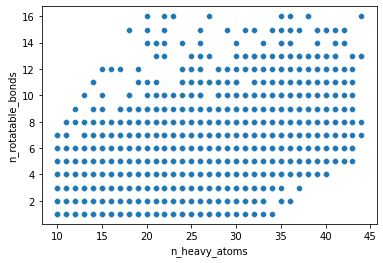

In [40]:
#plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_heavy_atoms', y='n_rotatable_bonds')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='mean_loss'>

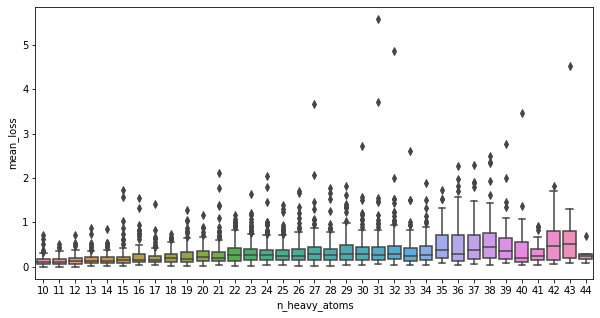

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='mean_loss')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='mean_loss'>

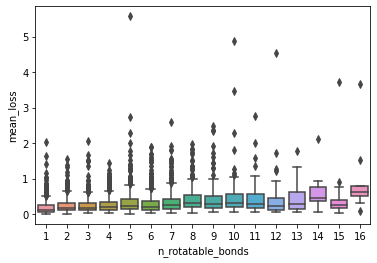

In [22]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='mean_loss')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_bioactive'>

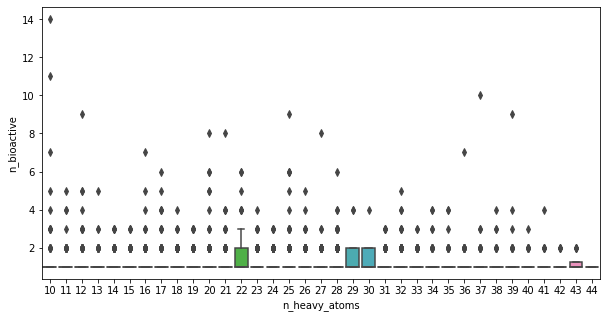

In [38]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_bioactive')

<AxesSubplot:xlabel='n_generated', ylabel='Count'>

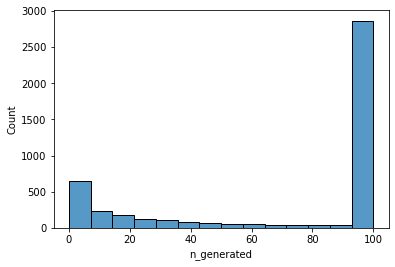

In [46]:
sns.histplot(data=t_nomicro, x='n_generated')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_generated'>

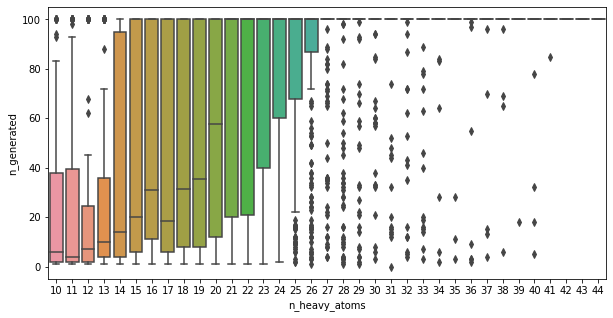

In [39]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_generated')

<AxesSubplot:xlabel='n_generated', ylabel='mean_loss'>

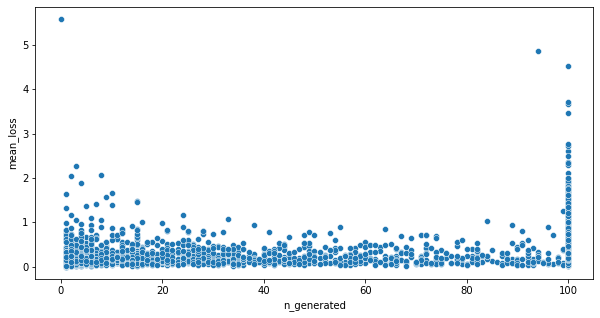

In [47]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_generated', y='mean_loss')

<AxesSubplot:xlabel='n_bioactive', ylabel='bioactive_accuracy'>

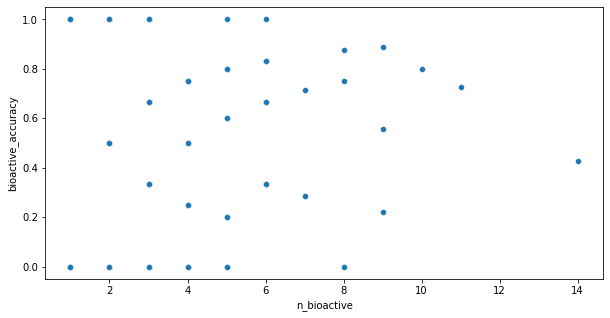

In [48]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='bioactive_accuracy')

<AxesSubplot:xlabel='n_bioactive', ylabel='median_bioactive_rank'>

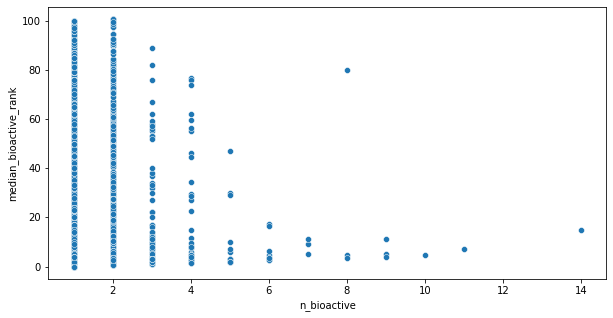

In [49]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='median_bioactive_rank'>

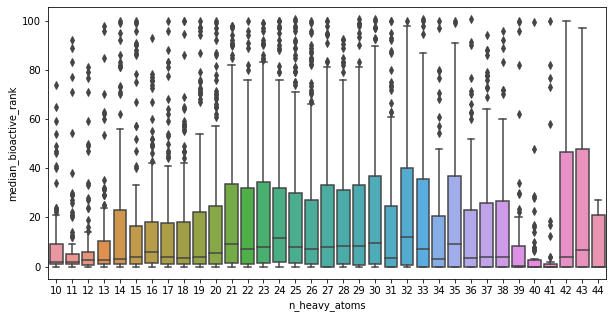

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='median_bioactive_rank'>

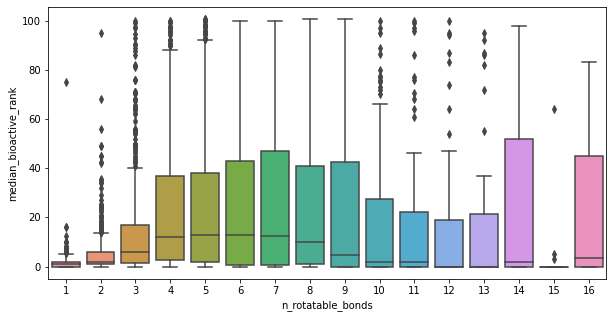

In [75]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='ef20_ccdc'>

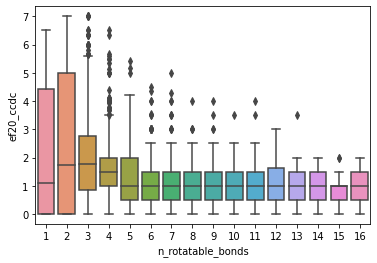

In [50]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_ccdc')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='ef20_pred'>

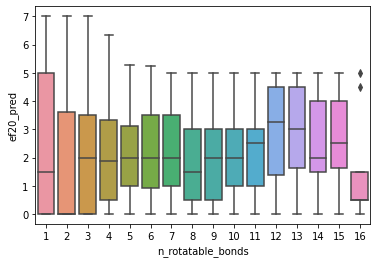

In [53]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_pred')

<AxesSubplot:xlabel='ef20_ccdc', ylabel='ef20_pred'>

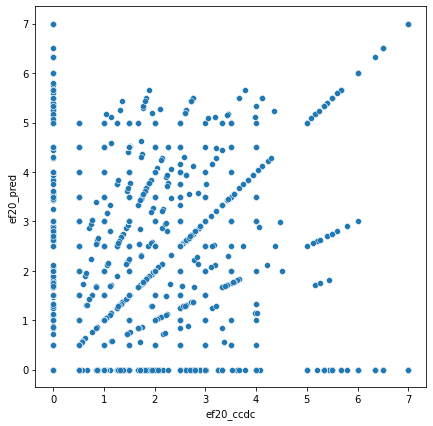

In [82]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=t_nomicro, x='ef20_ccdc', y='ef20_pred')

<AxesSubplot:xlabel='ef20_ccdc', ylabel='ef20_pred'>

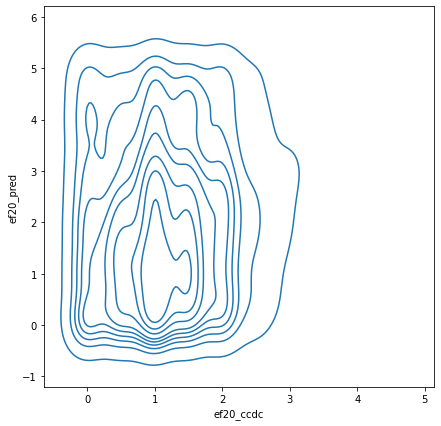

In [86]:
t_100gen = t_nomicro[t_nomicro['n_generated'] == 100]
plt.figure(figsize=(7,7))
sns.kdeplot(data=t_100gen, x='ef20_ccdc', y='ef20_pred')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_ccdc'>

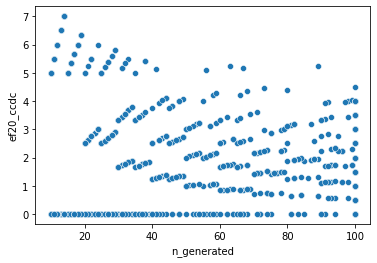

In [57]:
sns.scatterplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_pred'>

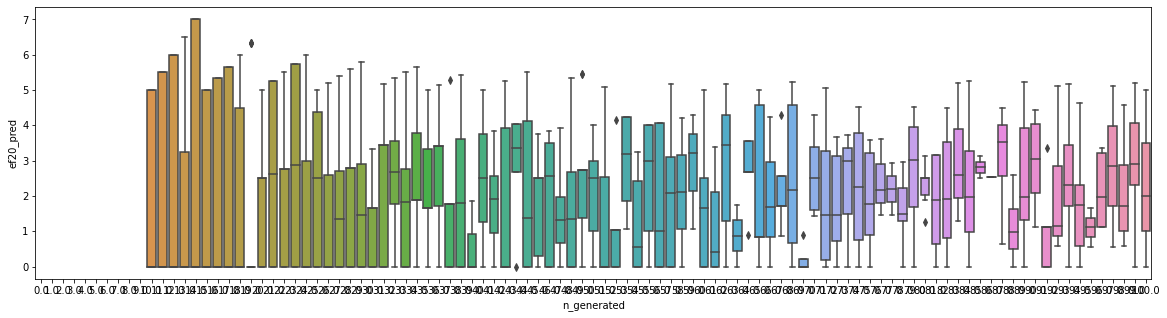

In [60]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_pred')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_ccdc'>

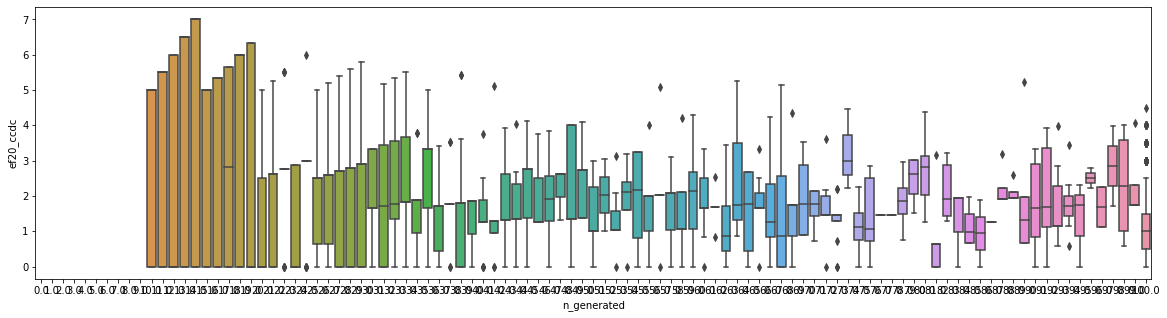

In [61]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='median_bioactive_rank'>

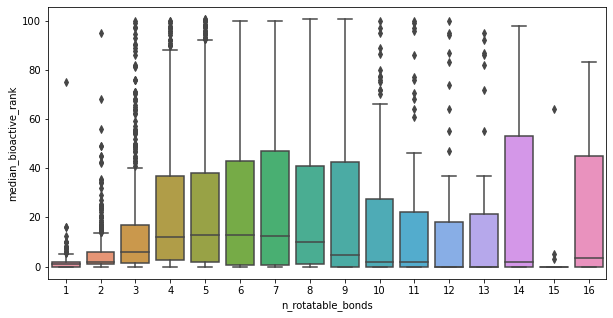

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='bioactive_accuracy'>

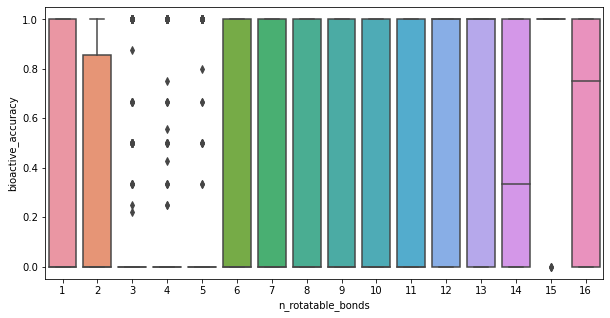

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='bioactive_accuracy')